## <span style="color: goldenrod;"><center>🌾 Detekcja kłosów pszenicy 🌾</center></span>




### <span style="color: wheat;">*Business understanding*</span>
Pszenica, jako podstawa codziennej diety dużej części społeczeństwa, jest poddawana wielu badaniom. Żmudną, ale istotną częścią tych badań jest pomiar cech roślin, takich jak ich wielkość, kolor, stopień rozwoju. Wiele czynności wciąż wykonywanych jest „ręcznie” – co oznacza, że jest to świetne pole do rozwoju poprzez zastosowanie uczenia maszynowego.

Dzięki szerokiej dostępności i rozwojowi cyfrowych aparatów fotograficznych, a teraz dronów i smartfonów, jesteśmy w stanie efektywnie pozyskać zdjęcia w terenie. Jednym z problemów, które postanowiono rozwiązać, jest szacowanie wielkości plonów za pośrednictwem liczenia kłosów pszenicy.

W latach 2016-2020 udało się pozyskać ponad 3400 zdjęć z doświadczalnych upraw pszenicy z Francji, Wielkiej Brytanii, Szwajcarii i Kanady wraz z wyznaczeniem parametrów ramek każdego kłosa występującego na tych zdjęciach. Na tej podstawie należy zbudować model, którego zadaniem będzie wykrywanie kłosów pszenicy oraz markowanie ich za pomocą ramek (*bounding boxes*).

Wykrywanie kłosów pszenicy może posłużyć do:
- wsparcia w badaniach naukowych - zbieranie danych na temat cech kłosów w celu badań nad uprawą, 
- szacowania wielkości plonów,
- automatycznego sterowania maszynami rolniczymi (optymalizacja zbioru, np. maszyna może dostosować prędkość i ustawienia na podstawie natężenia kłosów),
- oceny rozmiaru szkód po powodzi lub w przypadku innych klęsk żywiołowych.

Wyniki tego przedsięwzięcia będą determinowały późniejsze etapy rozwoju projektu (czy jest uzasadnione pozyskiwanie nowych danych, takich jak etap rozwoju, genotyp czy wykonywane zabiegi rolnicze).

In [1]:
running_in_COLAB = 'google.colab' in str(get_ipython()) if hasattr(
    __builtins__, '__IPYTHON__') else False
base_path = '.'
if running_in_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    base_path = '/content/drive/MyDrive/global-wheat-detection'

### >>>Imports

In [2]:
import os
import numpy as np
import pandas as pd
import random
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
import shutil
import zipfile
from sklearn.model_selection import train_test_split
import yaml

### Functions

In [3]:
def download_dataset(base_path='.'):
    os.environ['KAGGLE_CONFIG_DIR'] = f"{base_path}/"
    import kaggle
    kaggle.api.competition_download_files(
        'global-wheat-detection', path=f"{base_path}/"
    )
    if not os.path.exists(f"{base_path}/dataset") and \
            len(glob(f"{base_path}/dataset/train.csv")) == 0:
        with zipfile.ZipFile(
                glob(f"{base_path}/global-wheat-detection.zip")[0], 'r'
        ) as zip_file:
            zip_file.extractall(f"{base_path}/dataset")
    if os.path.exists(f"{base_path}/dataset/train"):
        os.rename(f"{base_path}/dataset/train", f"{base_path}/dataset/images")

In [4]:
# @title Create a bounding box
def create_bbox(image_id, df, column, color='red'):
    bboxes = df[df['image_id'] == image_id]
    for i in range(len(bboxes)):
        rectangle = patches.Rectangle(
            (bboxes['bbox_x_min'].iloc[i], bboxes['bbox_y_min'].iloc[i]),
            bboxes['bbox_width'].iloc[i],
            bboxes['bbox_height'].iloc[i],
            linewidth=1.5,
            edgecolor=color,
            facecolor='none')
        column.add_patch(rectangle)

In [5]:
# @title List with all bounding boxes for an image

def list_of_all_bboxes_in_image(df, image_id):
    img_bboxes = df[df['image_id'] == image_id]
    return img_bboxes[['bbox_x_min',
                       'bbox_y_min',
                       'bbox_width',
                       'bbox_height']].values.tolist()

In [6]:
# @title Number of bounding boxes for an image
def number_of_bboxes_in_image(bboxes_list: list) -> int:
    return len(bboxes_list)

In [7]:
# @title Plot sample images for every source
def plot_source_examples(df,
                         images_path,
                         samples_per_source=4,
                         size=(10, 20),
                         random_seed=11,
                         title='Image examples for each source'):
    np.random.seed(random_seed)
    sources = df['source'].unique()
    rows = len(sources)

    fig, ax = plt.subplots(rows, samples_per_source, figsize=size)
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for row, source in enumerate(sources):
        source_df = df[df['source'] == source]
        random_indices = np.random.choice(
            source_df.index, samples_per_source, replace=False)

        for column, index in enumerate(random_indices):
            img_id = source_df.loc[index, 'image_id']
            img = plt.imread(f'{images_path}{img_id}.jpg')
            ax[row, column].imshow(img)

            bboxes = list_of_all_bboxes_in_image(df, img_id)

            for bbox in bboxes:
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1,
                    edgecolor='r', facecolor='none')
                ax[row, column].add_patch(rect)

            ax[row, column].axis('off')

        ax[row, 0].set_title(f'Source: {source}')

    plt.suptitle(title, fontsize=16, y=0.92)

In [8]:
# @title Plot sample images with bounding boxes
def plot_sample_images(df,
                       images_path,
                       nrows=3,
                       ncols=3,
                       title='Sample images with bounding boxes',
                       bboxes=True):
    number_of_images = nrows * ncols
    samples = np.random.choice(
        np.unique(df['image_id'].tolist()),
        number_of_images
    )
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    i = 0
    fig.suptitle(title, fontsize=16, y=0.92)
    for row in ax:
        for column in row:
            img = plt.imread(f'{images_path}{samples[i]}.jpg')
            column.set_xticks([])
            column.set_yticks([])
            column.grid(False)
            if bboxes == True:
                create_bbox(samples[i], df, column, color='crimson')
            column.imshow(img)
            i += 1
    plt.show()

In [9]:
# @title create a bbox txt files for each image
def create_bbox_txt_files(df, output_folder):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    os.makedirs(output_folder)

    grouped = df.groupby('image_id')

    for image_id, group in grouped:
        output_file = os.path.join(output_folder, f'{image_id}.txt')
        with open(output_file, 'w') as file:
            for _, row in group.iterrows():
                file.write(
                    f"{row['class']} \
                    {row['bbox_x_center']} \
                    {row['bbox_y_center']} \
                    {row['bbox_width']} \
                    {row['bbox_height']}\n"
                )

In [10]:
def plot_test_images(test_images_path,
                     number_of_images_to_plot=1,
                     figsize=(7, 7)):
    images = [file for file in os.listdir(
        test_images_path) if file.endswith('.jpg')]
    images = random.sample(images, number_of_images_to_plot)
    for i in range(number_of_images_to_plot):
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        img = plt.imread(os.path.join(test_images_path, images[i]))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        plt.show()

### <span style="color: wheat;">*Dataset understanding*</span>

#### Files:

- 3422 training images 1024x1024 px
- train.csv - training data
- 10 test images 1024x1024 px

#### train.csv:

- image_id - the unique image ID
- width, height - the width and height of the images
- bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
- source - the university that prepared the data

In [11]:
# @title Data
download_dataset(base_path=base_path)

images_path = f'{base_path}/dataset/images/'
df = pd.read_csv(f'{base_path}/dataset/train.csv')

all_images = os.listdir(images_path)
all_images = [
    f for f in all_images if os.path.isfile(images_path + '/' + f)
]
all_images = [f.split('.')[0] for f in all_images]

In [12]:
df[120:140]

image_id  width  height                          bbox   source
120  7b72ea0fb   1024    1024    [579.0, 256.0, 96.0, 89.0]  usask_1
121  7b72ea0fb   1024    1024    [168.0, 187.0, 90.0, 43.0]  usask_1
122  7b72ea0fb   1024    1024    [232.0, 565.0, 59.0, 91.0]  usask_1
123  7b72ea0fb   1024    1024    [300.0, 527.0, 68.0, 57.0]  usask_1
124  7b72ea0fb   1024    1024     [69.0, 722.0, 61.0, 58.0]  usask_1
125  7b72ea0fb   1024    1024   [722.0, 783.0, 90.0, 130.0]  usask_1
126  7b72ea0fb   1024    1024   [800.0, 442.0, 80.0, 105.0]  usask_1
127  7b72ea0fb   1024    1024  [840.0, 456.0, 134.0, 180.0]  usask_1
128  7b72ea0fb   1024    1024    [853.0, 509.0, 99.0, 90.0]  usask_1
129  7b72ea0fb   1024    1024    [39.0, 843.0, 108.0, 54.0]  usask_1
130  7b72ea0fb   1024    1024    [216.0, 791.0, 80.0, 42.0]  usask_1
131  7b72ea0fb   1024    1024    [325.0, 726.0, 59.0, 54.0]  usask_1
132  7b72ea0fb   1024    1024    [195.0, 580.0, 28.0, 30.0]  usask_1
133  7b72ea0fb   1024    1024    [333.0, 124.0, 44.0, 46.0]  usask_1
134  91c9d9c38   1024    1024    [124.0, 273.0, 59.0, 73.0]  usask_1
135  91c9d9c38   1024    1024    [688.0, 939.0, 61.0, 85.0]  usask_1
136  91c9d9c38   1024    1024    [639.0, 674.0, 83.0, 41.0]  usask_1
137  91c9d9c38   1024    1024    [562.0, 410.0, 96.0, 83.0]  usask_1
138  91c9d9c38   1024    1024     [665.0, 92.0, 96.0, 78.0]  usask_1
139  91c9d9c38   1024    1024    [0.0, 317.0, 103.0, 138.0]  usask_1

In [13]:
print(f'Number of images: {len(all_images)}')
print(f'Data contains: {df.shape[0]} bounding boxes')

Number of images: 3422
Data contains: 147793 bounding boxes


In [14]:
# @title Image shape
width = df['width'].unique()
height = df['height'].unique()
if (len(width), len(height)) == (1, 1):
    print(f'Every image has the same shape: {width[0]}px x {height[0]}px')
else:
    print('Images have different sizes')

Every image has the same shape: 1024px x 1024px


In [15]:
# @title Missing values

missing_values = df.isnull() \
    .sum() \
    .rename('number of missing values') \
    .to_frame()
missing_values

number of missing values
image_id                         0
width                            0
height                           0
bbox                             0
source                           0

Every row in data is complete.

In [16]:
# @title Images without marked spikes (bounding boxes)

all_images = pd.DataFrame(all_images)
all_images.columns = ['image_id']

images_id_in_df = set(df['image_id'])

images_without_bboxes = all_images[
    all_images['image_id'].apply(lambda x: x not in images_id_in_df)
]

print(f'Thera are {len(images_without_bboxes)} images without bouding boxes.')

Thera are 49 images without bouding boxes.


In [17]:
# # @title Coordinates separation

bbox_x_min, bbox_y_min, bbox_width, bbox_height = zip(
    *(ast.literal_eval(i) for i in df["bbox"])
)

In [18]:
df["bbox_x_min"] = bbox_x_min
df["bbox_y_min"] = bbox_y_min
df["bbox_width"] = bbox_width
df["bbox_height"] = bbox_height

df["bbox_x_center"] = df["bbox_x_min"] + df["bbox_width"]/2
df["bbox_y_center"] = df["bbox_y_min"] + df["bbox_height"]/2

df["bbox_x_min"] = df["bbox_x_min"].astype(int)
df["bbox_y_min"] = df["bbox_y_min"].astype(int)
df["bbox_width"] = df["bbox_width"].astype(int)
df["bbox_height"] = df["bbox_height"].astype(int)

df.tail(10)

image_id  width  height                          bbox     source  \
147783  5e0747034   1024    1024    [668.0, 81.0, 110.0, 70.0]  arvalis_2   
147784  5e0747034   1024    1024      [716.0, 7.0, 80.0, 64.0]  arvalis_2   
147785  5e0747034   1024    1024  [217.0, 865.0, 115.0, 102.0]  arvalis_2   
147786  5e0747034   1024    1024     [916.0, 46.0, 64.0, 56.0]  arvalis_2   
147787  5e0747034   1024    1024    [852.0, 640.0, 82.0, 94.0]  arvalis_2   
147788  5e0747034   1024    1024     [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024   [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024   [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024    [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024    [875.0, 740.0, 94.0, 61.0]  arvalis_2   

        bbox_x_min  bbox_y_min  bbox_width  bbox_height  bbox_x_center  \
147783         668          81         110           70          723.0   
147784         716           7          80           64          756.0   
147785         217         865         115          102          274.5   
147786         916          46          64           56          948.0   
147787         852         640          82           94          893.0   
147788          64         619          84           95          106.0   
147789         292         549         107           82          345.5   
147790         134         228         141           71          204.5   
147791         430          13         184           79          522.0   
147792         875         740          94           61          922.0   

        bbox_y_center  
147783          116.0  
147784           39.0  
147785          916.0  
147786           74.0  
147787          687.0  
147788          666.5  
147789          590.0  
147790          263.5  
147791           52.5  
147792          770.5

In [19]:
bboxes_per_image = df[['image_id', 'source']] \
    .value_counts() \
    .to_frame() \
    .reset_index() \
    .rename(columns={'count': 'number_of_bboxes', })
bboxes_per_image.sample(15)

image_id     source  number_of_bboxes
1254  82f65a5ca  arvalis_1                51
1842  aa457091c  arvalis_1                40
170   2073fe7f7     ethz_1                78
2349  d89b34cb1    usask_1                31
2268  e4cc39cbf  arvalis_2                32
912   bc49e2888     rres_1                57
90    47e218059  arvalis_1                82
1058  0d2e2b65b  arvalis_1                55
3105  ccb8097e3  arvalis_2                16
1318  b6a159fd4  arvalis_1                50
154   681baf2e2     ethz_1                79
1844  150cabe75    usask_1                40
1645  a6c205e19     rres_1                44
87    7c3570738     ethz_1                83
1188  7ebf61d5a  arvalis_1                52

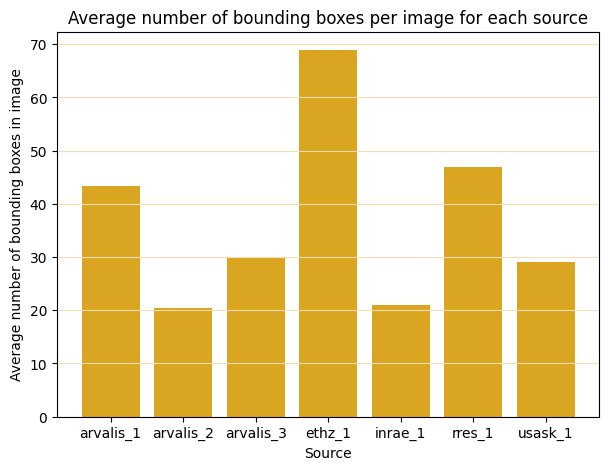

In [20]:
mean_bboxes_per_source = bboxes_per_image.groupby(
    'source')['number_of_bboxes'].mean()
plt.figure(figsize=(7, 5))
plt.bar(mean_bboxes_per_source.index,
        mean_bboxes_per_source.values, color='goldenrod')
plt.xlabel('Source')
plt.ylabel('Average number of bounding boxes in image')
plt.grid(axis='y', color='wheat')
plt.title('Average number of bounding boxes per image for each source')

plt.show()

In [21]:
institutes = {
    'Sub-dataset name': [
        'Arvalis_1', 'Arvalis_2', 'Arvalis_3',
        'INRAE_1', 'USask_1', 'RRes_1', 'ETHZ_1'
    ],
    'Institution': [
        'Arvalis, Institut technique agricole',
        'Arvalis, Institut technique agricole',
        'Arvalis, Institut technique agricole',
        "INRAE, Institut National de Recherche pour \
        l'Agriculture, l'Alimentation et l'Environnement",
        'University of Saskatchewan', 'Rothamsted research',
        'ETHZ, Eidgenössische Technische Hochschule Zürich'
    ],
    'Country': [
        'France', 'France', 'France', 'France', 'Canada',
        'UK', 'Switzerland'
    ],
    'Targeted stages': [
        'Postflowering-ripening', 'Postflowering',
        'Postflowering-ripening', 'Postflowering',
        'n.a', 'n.a', 'n.a'
    ],
    'Sowing density (seeds/m2)': [300, 300, 300, 300, 250, 350, 400]
}
institutes_df = pd.DataFrame(institutes)
institutes_df

Sub-dataset name                                        Institution  \
0        Arvalis_1               Arvalis, Institut technique agricole   
1        Arvalis_2               Arvalis, Institut technique agricole   
2        Arvalis_3               Arvalis, Institut technique agricole   
3          INRAE_1  INRAE, Institut National de Recherche pour    ...   
4          USask_1                         University of Saskatchewan   
5           RRes_1                                Rothamsted research   
6           ETHZ_1  ETHZ, Eidgenössische Technische Hochschule Zürich   

       Country         Targeted stages  Sowing density (seeds/m2)  
0       France  Postflowering-ripening                        300  
1       France           Postflowering                        300  
2       France  Postflowering-ripening                        300  
3       France           Postflowering                        300  
4       Canada                     n.a                        250  
5           UK                     n.a                        350  
6  Switzerland                     n.a                        400

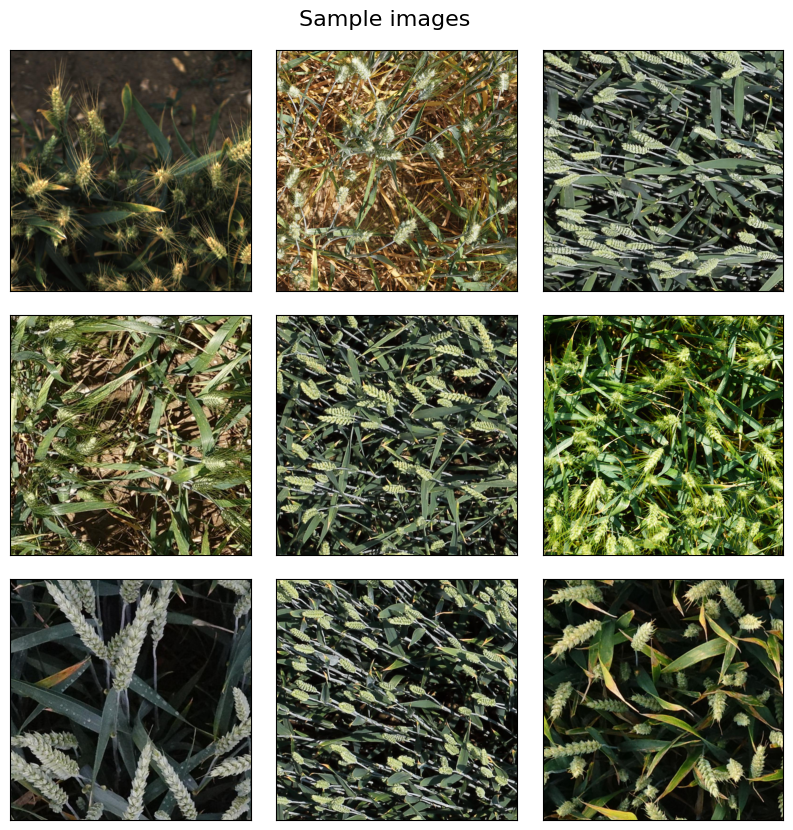

In [22]:
# @title Sample images
np.random.seed(17)
samples = np.random.choice(np.unique(df['image_id'].tolist()), 9)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.suptitle('Sample images', fontsize=16, y=0.92)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

i = 0
for row in ax:
    for col in row:
        img = plt.imread(f'{images_path}{samples[i]}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        i += 1
plt.show()

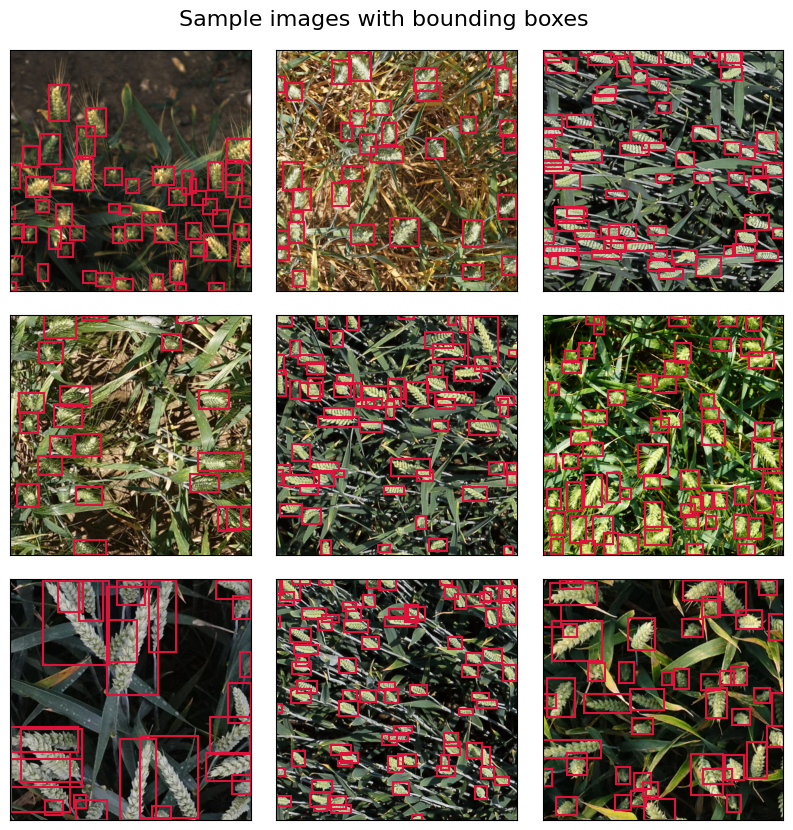

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
i = 0
fig.suptitle('Sample images with bounding boxes', fontsize=16, y=0.92)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for row in ax:
    for column in row:
        img = plt.imread(f'{images_path}{samples[i]}.jpg')
        column.set_xticks([])
        column.set_yticks([])
        column.grid(False)
        create_bbox(samples[i], df, column, color='crimson')
        column.imshow(img)
        i += 1
plt.show()

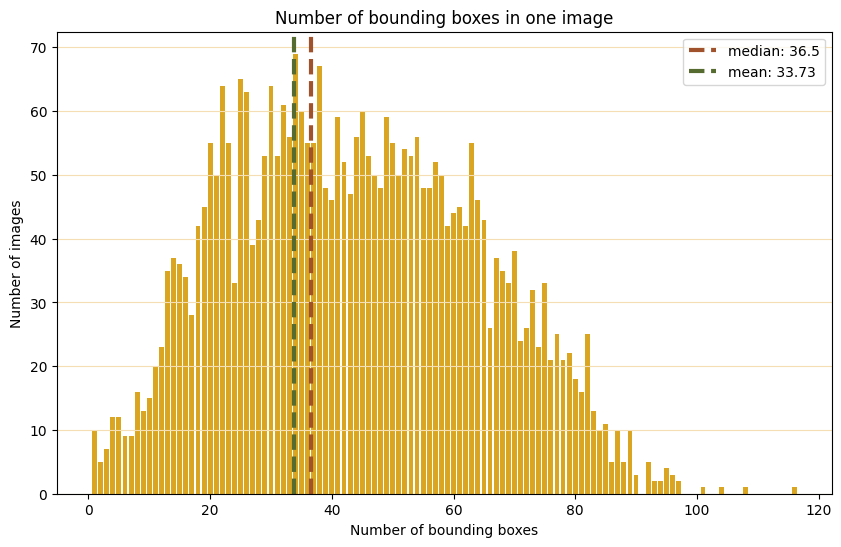

In [24]:
# @title Number of bounding boxes in one image
bbox_counts = bboxes_per_image.groupby('number_of_bboxes').size()
plt.figure(figsize=(10, 6))
plt.bar(bbox_counts.index, bbox_counts.values, color='goldenrod')
plt.xlabel('Number of bounding boxes')
plt.ylabel('Number of images')
plt.grid(axis='y', color='wheat')
plt.title('Number of bounding boxes in one image')

median_value = bbox_counts.median()
mean_value = bbox_counts.mean()
plt.axvline(median_value, color='sienna', linestyle='--',
            linewidth=3, label=f'median: {median_value}')
plt.axvline(mean_value, color='darkolivegreen', linestyle='--',
            linewidth=3, label=f'mean: {mean_value}')
plt.legend()
plt.show()

In [25]:
# @title Images with less than 10 marked spikes (bounding boxes)
less_than_10_spikes = bboxes_per_image[
    bboxes_per_image['number_of_bboxes'] < 10
]
less_than_10_spikes

image_id     source  number_of_bboxes
3280  4f4c6ee91  arvalis_3                 9
3281  d950bfe39  arvalis_2                 9
3282  10c2f7946  arvalis_3                 9
3283  250233aea  arvalis_3                 9
3284  b7d03627f  arvalis_2                 9
...         ...        ...               ...
3368  22f341965  arvalis_3                 1
3369  86296fc32  arvalis_3                 1
3370  ce4124be0  arvalis_3                 1
3371  a5cb30c38  arvalis_3                 1
3372  76595919e  arvalis_3                 1

[93 rows x 3 columns]

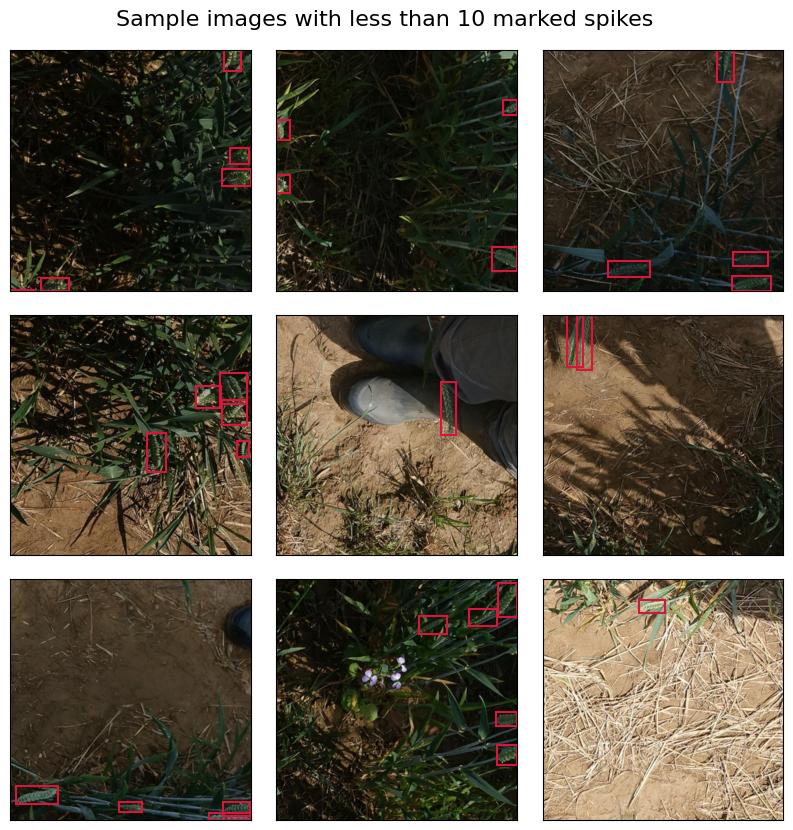

In [26]:
plot_sample_images(df=df[df["image_id"].isin(less_than_10_spikes["image_id"])],
                   images_path=images_path,
                   title='Sample images with less than 10 marked spikes'
                   )

In [27]:
# @title Images with more than 80 marked spikes (bounding boxes)
more_than_80_spikes = bboxes_per_image[
    bboxes_per_image['number_of_bboxes'] > 80
]
more_than_80_spikes.tail()

image_id  source  number_of_bboxes
125  c64a8e237  ethz_1                81
126  99d221ffe  ethz_1                81
127  a047ef30d  ethz_1                81
128  f49d9b7d6  ethz_1                81
129  832555118  ethz_1                81

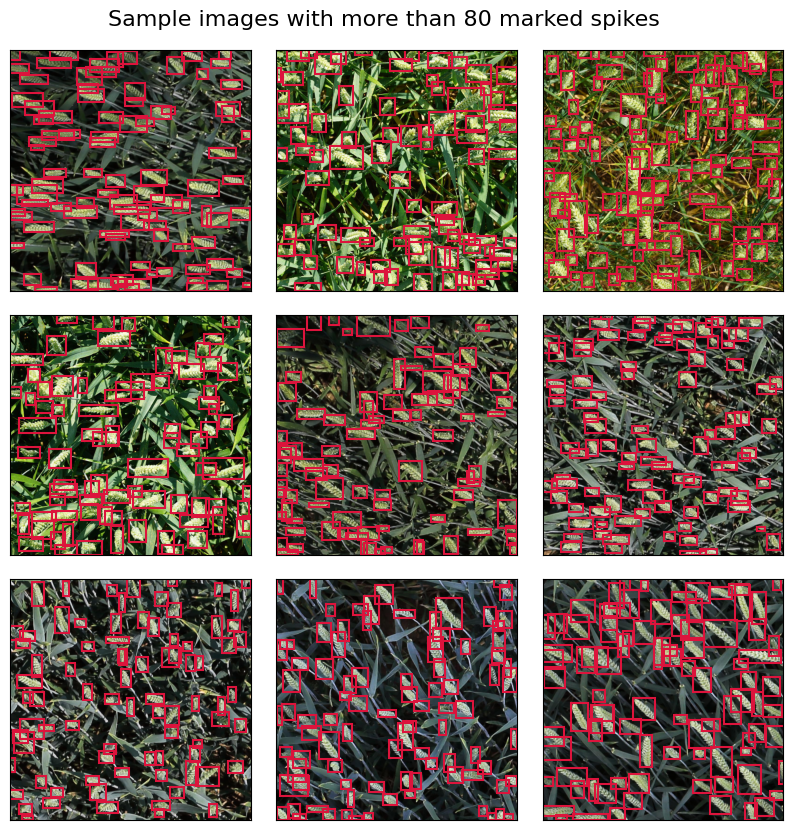

In [28]:
plot_sample_images(df=df[df["image_id"].isin(more_than_80_spikes["image_id"])],
                   images_path=images_path,
                   title='Sample images with more than 80 marked spikes'
                   )

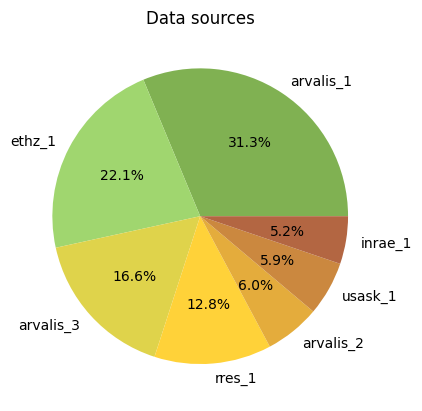

In [29]:
# @title Sources

sources = df.groupby('image_id')['source'].first().value_counts().to_frame()
labels = sources.index
colors = ['#80B152', '#A0D66F', '#DFD34B', '#FFD239',
          '#E4AC3C', '#CB883F', '#B36642', '#9A4444', '#8C3C3C']
plt.pie(sources['count'], colors=colors, autopct='%1.1f%%', labels=labels)
plt.title('Data sources')
plt.show()

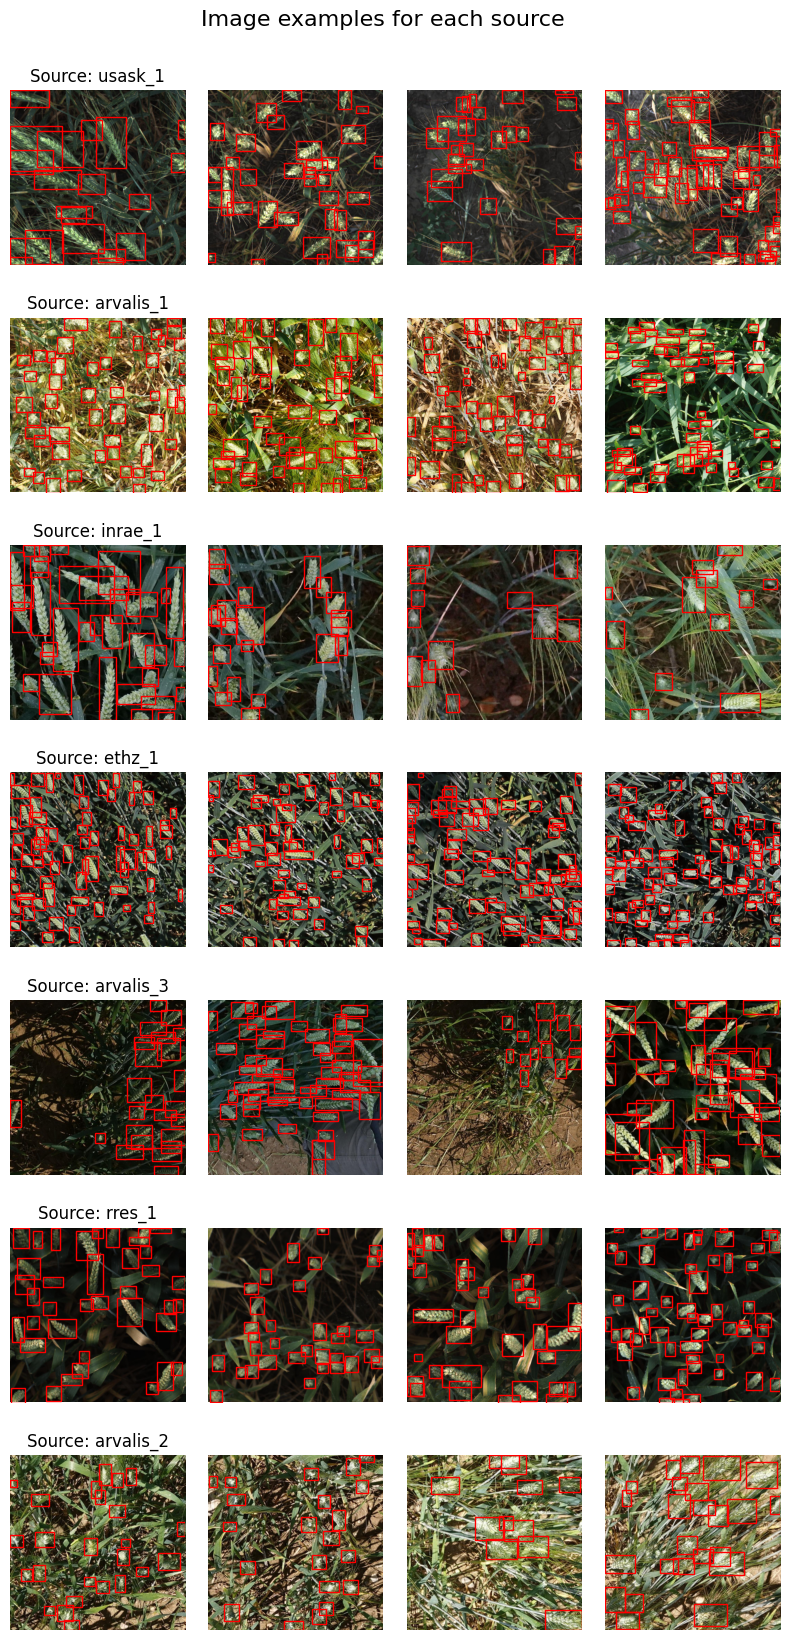

In [30]:
plot_source_examples(df=df, images_path=images_path)

### <span style="color: wheat;">*Data preparation*</span>

In [31]:
train_df = df.drop(columns=['width', 'height', 'bbox', 'source'])
train_df['class'] = 0
train_df[
    ['bbox_x_min', 'bbox_y_min', 'bbox_x_center',
     'bbox_y_center', 'bbox_width', 'bbox_height']] = train_df[
    ['bbox_x_min', 'bbox_y_min', 'bbox_x_center',
     'bbox_y_center', 'bbox_width', 'bbox_height']]/1024.0

train_df.tail(10)

image_id  bbox_x_min  bbox_y_min  bbox_width  bbox_height  \
147783  5e0747034    0.652344    0.079102    0.107422     0.068359   
147784  5e0747034    0.699219    0.006836    0.078125     0.062500   
147785  5e0747034    0.211914    0.844727    0.112305     0.099609   
147786  5e0747034    0.894531    0.044922    0.062500     0.054688   
147787  5e0747034    0.832031    0.625000    0.080078     0.091797   
147788  5e0747034    0.062500    0.604492    0.082031     0.092773   
147789  5e0747034    0.285156    0.536133    0.104492     0.080078   
147790  5e0747034    0.130859    0.222656    0.137695     0.069336   
147791  5e0747034    0.419922    0.012695    0.179688     0.077148   
147792  5e0747034    0.854492    0.722656    0.091797     0.059570   

        bbox_x_center  bbox_y_center  class  
147783       0.706055       0.113281      0  
147784       0.738281       0.038086      0  
147785       0.268066       0.894531      0  
147786       0.925781       0.072266      0  
147787       0.872070       0.670898      0  
147788       0.103516       0.650879      0  
147789       0.337402       0.576172      0  
147790       0.199707       0.257324      0  
147791       0.509766       0.051270      0  
147792       0.900391       0.752441      0

In [32]:
train_images, val_images = train_test_split(
    all_images, test_size=0.2
)

In [33]:
val_images

image_id
2839  d557e8635
1186  59dbb2e28
178   0dc9eb168
1628  7c91c33f0
810   3ff643a64
...         ...
1684  80ea429bf
300   1708360c3
2601  c35347675
1569  7826a88b5
1895  8fee7acd5

[685 rows x 1 columns]

In [34]:
print(f'Train images in val images: \
    {train_images["image_id"].isin(val_images["image_id"]).sum()}')
print(f'Val images in train images: \
    {val_images["image_id"].isin(train_images["image_id"]).sum()}')

Train images in val images:     0
Val images in train images:     0


In [35]:
train_images_list = train_images['image_id'].to_list()
train_images_list = [
    f'./images/{image_id}.jpg' for image_id in train_images_list
]
with open(f'{base_path}/dataset/train.txt', 'w') as f:
    f.write('\n'.join(train_images_list))

val_images_list = val_images['image_id'].to_list()
val_images_list = [
    f'./images/{image_id}.jpg' for image_id in val_images_list
]
with open(f'{base_path}/dataset/val.txt', 'w') as f:
    f.write('\n'.join(val_images_list))

In [36]:
df_train = train_df[train_df["image_id"].isin(list(train_images['image_id']))]
df_val = train_df[train_df["image_id"].isin(list(val_images['image_id']))]

df_train = df_train.drop(columns=['bbox_x_min', 'bbox_y_min'], axis=1)
df_val = df_val.drop(columns=['bbox_x_min', 'bbox_y_min'], axis=1)

In [37]:
df_train

image_id  bbox_width  bbox_height  bbox_x_center  bbox_y_center  \
0       b6ab77fd7    0.054688     0.035156       0.841797       0.234375   
1       b6ab77fd7    0.126953     0.056641       0.284180       0.563477   
2       b6ab77fd7    0.072266     0.156250       0.404297       0.570312   
3       b6ab77fd7    0.106445     0.104492       0.867676       0.145020   
4       b6ab77fd7    0.121094     0.114258       0.085938       0.197754   
...           ...         ...          ...            ...            ...   
147788  5e0747034    0.082031     0.092773       0.103516       0.650879   
147789  5e0747034    0.104492     0.080078       0.337402       0.576172   
147790  5e0747034    0.137695     0.069336       0.199707       0.257324   
147791  5e0747034    0.179688     0.077148       0.509766       0.051270   
147792  5e0747034    0.091797     0.059570       0.900391       0.752441   

        class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
147788      0  
147789      0  
147790      0  
147791      0  
147792      0  

[118554 rows x 6 columns]

In [38]:
print(f"Number of train images: {len(train_images)}")
print(f"Number of val images: {len(val_images)}")

Number of train images: 2737
Number of val images: 685


In [39]:
# @title Create file with bounding boxes for each image
labels_path = f"{base_path}/dataset/labels"
create_bbox_txt_files(train_df, labels_path)

### <span style="color: wheat;">*Modeling*</span>

In [40]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5

In [41]:
%pip install -r yolov5/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [42]:
wheat_data_for_yolo = {
    'path': f'{base_path}/dataset' if running_in_COLAB else '../dataset',
    'train': 'train.txt',
    'val': 'val.txt',
    'test': 'test',
    'nc': 1,  # number of classes
    'names': ['wheat']
}

with open(f'{base_path}/yolo_configs/wheat_yaml.yaml', 'w') as wheat_yaml:
    yaml.dump(wheat_data_for_yolo, wheat_yaml)

# Model bazowy YOLOv5s

In [43]:
if not os.path.exists(f'{base_path}/yolo_configs'):
    os.makedirs(f'{base_path}/yolo_configs')
shutil.copy('./yolov5/models/yolov5s.yaml',
            f'{base_path}/yolo_configs/yolov5s.yaml')

'./yolo_configs/yolov5s.yaml'

In [52]:
%run yolov5/train.py \
  --img 1024 \
  --batch 16 \
  --epochs 2 \
  --data {base_path}/yolo_configs/wheat_yaml.yaml \
  --cfg {base_path}/yolo_configs/yolov5s.yaml \
  --weights yolov5s.pt \
  --project {base_path}/yolo_results \
  --name yolov5s_basic_model \
  --cache 

train: weights=yolov5s.pt, cfg=./yolo_configs/yolov5s.yaml, data=./yolo_configs/wheat_yaml.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=2, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=./yolo_results, name=yolov5s_basic_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-230-g53efd07f Python-3.10.13 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1

# Model YOLOv5m

In [53]:
if not os.path.exists(f'{base_path}/yolo_configs'):
    os.makedirs(f'{base_path}/yolo_configs')
shutil.copy('./yolov5/models/yolov5m.yaml',
            f'{base_path}/yolo_configs/yolov5m.yaml')

'./yolo_configs/yolov5m.yaml'

In [46]:
%run yolov5/train.py \
  --img 1024 \
  --batch 2 \
  --epochs 2 \
  --data {base_path}/yolo_configs/wheat_yaml.yaml \
  --cfg {base_path}/yolo_configs/yolov5m.yaml \
  --weights yolov5m.pt \
  --project {base_path}/yolo_results \
  --name yolov5m_model \
  --cache 

train: weights=yolov5m.pt, cfg=./yolo_configs/yolov5m.yaml, data=./yolo_configs/wheat_yaml.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=2, batch_size=2, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=./yolo_results, name=yolov5m_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-230-g53efd07f Python-3.10.13 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj

# Model YOLOv5x

In [54]:
if not os.path.exists(f'{base_path}/yolo_configs'):
    os.makedirs(f'{base_path}/yolo_configs')
shutil.copy('./yolov5/models/yolov5x.yaml',
            f'{base_path}/yolo_configs/yolov5x.yaml')

'./yolo_configs/yolov5x.yaml'

In [84]:
%run yolov5/train.py \
  --img 1024 \
  --batch 2 \
  --epochs 20 \
  --data {base_path}/yolo_configs/wheat_yaml.yaml \
  --cfg {base_path}/yolo_configs/yolov5x.yaml \
  --weights yolov5x.pt \
  --project {base_path}/yolo_results \
  --name yolov5x_batch2_epoch20 \
  --cache 

train: weights=yolov5x.pt, cfg=./yolo_configs/yolov5x.yaml, data=./yolo_configs/wheat_yaml.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=2, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=./yolo_results, name=yolov5x_batch2_epoch20, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-230-g53efd07f Python-3.10.13 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, ob